# Evaluating New York Public Library Usage and the Unemployment Rate

### by Kate Cauley

# Importing Packages

In [1]:
import os
import math
import io
import warnings
from os import listdir
from os.path import isfile, join
from __future__ import print_function, division
warnings.filterwarnings("ignore")

import requests
import shapely
import json
import urllib

import pandas as pd
import scipy as sp
import pylab as pl
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy import stats
from fiona.crs import from_epsg
from matplotlib import cycler
from matplotlib.pyplot import rcParams

%pylab inline

IPython_default = plt.rcParams.copy()

colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)


from censusAPI import myAPI

Populating the interactive namespace from numpy and matplotlib


In [2]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = '%s/Puidata'%os.getenv("HOME")

In [3]:
os.getenv('PUIDATA')

'/nfshome/kc116/PUIdata'

Let's create a folder called **ec_project_data** in my PUIDATA environment to store all my data in one place.

In [4]:
os.system("mkdir %s/ec_project_data"%os.getenv("PUIDATA"))

0

In [5]:
!ls $PUIDATA

2010Average_Daily_Inmate_Population.csv
201501Average_Daily_Inmate_Population.csv
acs15_final.csv
Average_Daily_Inmate_Population.csv
BK18v1.csv
CartoDBQueryingB (1).ipynb
CartoDBQuerying.ipynb
censusAPI.py
census_data
census_tract_data.gz
-citibike-tripdata.csv
death.csv
dhsdaily.csv
ec_project_data
Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv
fbb_matplotlibrc.json
file.gz
geo_export_0f6bc099-d1dd-4e0e-973d-047613e6061d.dbf
geo_export_0f6bc099-d1dd-4e0e-973d-047613e6061d.prj
geo_export_0f6bc099-d1dd-4e0e-973d-047613e6061d.shp
geo_export_0f6bc099-d1dd-4e0e-973d-047613e6061d.shx
geo_export_1f84b397-da65-40f6-b666-a0ad7c9cecca.dbf
geo_export_1f84b397-da65-40f6-b666-a0ad7c9cecca.prj
geo_export_1f84b397-da65-40f6-b666-a0ad7c9cecca.shp
geo_export_1f84b397-da65-40f6-b666-a0ad7c9cecca.shx
geo_export_d7557dbf-0ee0-4f25-85f4-db5b0d815705.dbf
geo_export_d7557dbf-0ee0-4f25-85f4-db5b0d815705.prj
geo_export_d7557dbf-0ee0-4f25-85f4-db5b0d815705.shp
geo_export_d7557dbf-0ee0-4f25-85f4-

# Datasets Needed

I will need the following datasets:

**1. ACS 2010 (5 year Survey)** - To get unemployment rate information per (census tract, borough)

**2. Library Data** - To get library attendance information in New York City

**3. Census Tract Data** - To get location information of every census tract across all the boroughs

# Dataset 1. ACS 2010 (5 year Survey)

Initially, I tried using the American Fact Finder (AFF) API to get the data. However, I was encountering issues with getting the data per (census tract, boro) as the API wanted me to specify the county for each census tract.

I figured that it would be easier and faster to directly download the data from the AFF Website. Here are the exact steps I took to procure the dataset:

1.Navigate to https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml 


2.Select **'I know the dataset or table(s) that I want to download.'** and click **'Next'**.


3.Select the **'American Community Survey'** and choose **'2010 ACS 5-year estimates'**, then click **'Add to your Selections'**. Click **'Next'**.


4.For **'Select a geographic type'**, select **'Census Tract - 140'**. Then choose **'New York'** as the **'State'**. Do not select a county as we want multiple counties. Finally, choose **'All Census Tracts within New York'** and click **'Add to your Selections'**. Click **'Next'**.


5.On this page, navigate to page 34 and select the table with the ID **'C23002G'**. It corresponds to **'SEX BY AGE BY EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER (TWO OR MORE RACES)'**. Click **'Next'**.


6.A pop up opens. Select **'OK'**. After a few seconds, the download button should appear. Click **'Download'**. A file called **'aff_download.zip'** will be downloaded.


7.Upload the aff_download.zip to CUSP ADRF -> I did this using SFTP by referencing this link: http://cusp.adrf.cloud/sftp 

Let's unzip the aff_download inside our ec_project_data folder.

In [12]:
os.system("unzip aff_download.zip -d %s/ec_project_data"%os.getenv("PUIDATA"))
# os.system("unzip -u aff_download.zip")

0

Confirming that aff_download was unzipped.

In [13]:
!ls $PUIDATA/ec_project_data

ACS_10_5YR_C23002G_metadata.csv  ACS_10_5YR_C23002G_with_ann.csv
ACS_10_5YR_C23002G.txt		 aff_download_readme_ann.txt


We will read the **ACS_10_5YR_C23002G_with_ann.csv** file as it looks to be the main csv file.

In [14]:
aff_df = pd.read_csv('%s/ec_project_data/ACS_10_5YR_C23002G_with_ann.csv'%os.getenv("PUIDATA"))

aff_df.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,...,HD01_VD24,HD02_VD24,HD01_VD25,HD02_VD25,HD01_VD27,HD02_VD27,HD01_VD28,HD02_VD28,HD01_VD29,HD02_VD29
0,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Male:,Margin of Error; Male:,Estimate; Male: - 16 to 64 years:,Margin of Error; Male: - 16 to 64 years:,Estimate; Male: - 16 to 64 years: - In labor f...,...,Estimate; Female: - 65 years and over:,Margin of Error; Female: - 65 years and over:,Estimate; Female: - 65 years and over: - In la...,Margin of Error; Female: - 65 years and over: ...,Estimate; Female: - 65 years and over: - In la...,Margin of Error; Female: - 65 years and over: ...,Estimate; Female: - 65 years and over: - In la...,Margin of Error; Female: - 65 years and over: ...,Estimate; Female: - 65 years and over: - Not i...,Margin of Error; Female: - 65 years and over: ...
1,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",58,61,0,123,0,123,0,...,0,123,0,123,0,123,0,123,0,123
2,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",132,152,52,59,52,59,24,...,0,123,0,123,0,123,0,123,0,123
3,1400000US36001000300,36001000300,"Census Tract 3, Albany County, New York",35,43,35,43,35,43,27,...,0,123,0,123,0,123,0,123,0,123
4,1400000US36001000401,36001000401,"Census Tract 4.01, Albany County, New York",17,28,0,123,0,123,0,...,0,123,0,123,0,123,0,123,0,123


Based on the metadata that was provided with the main data,

**HD01_VD08** - corresponds to Male Estimates (16-64 years old) for unemployed civilians <br />
**HD01_VD22** - corresponds to Female Estimates (16-64 years old) for unemployed civilians <br />
**HD01_VD01** - corresponds to Total Surveyed Population

In [15]:
# selecting the required columns
aff_df = aff_df.loc[:, ['GEO.display-label', 'HD01_VD08', 'HD01_VD22', 'HD01_VD01']]

# dropping the first row
aff_df = aff_df.drop(aff_df.index[[0]]).reset_index(drop=True)

# visualizing the head
aff_df.head()

,GEO.display-label,HD01_VD08,HD01_VD22,HD01_VD01
0,"Census Tract 1, Albany County, New York",0,0,58
1,"Census Tract 2, Albany County, New York",0,0,132
2,"Census Tract 3, Albany County, New York",0,0,35
3,"Census Tract 4.01, Albany County, New York",0,0,17
4,"Census Tract 4.03, Albany County, New York",20,0,65


Let us inspect the **GEO.display-label** column more closely.

In [16]:
aff_df['GEO.display-label'].unique()[0::50]

array(['Census Tract 1, Albany County, New York',
       'Census Tract 140.02, Albany County, New York',
       'Census Tract 31, Bronx County, New York',
       'Census Tract 98, Bronx County, New York',
       'Census Tract 183.01, Bronx County, New York',
       'Census Tract 233.02, Bronx County, New York',
       'Census Tract 293.01, Bronx County, New York',
       'Census Tract 371, Bronx County, New York',
       'Census Tract 423, Bronx County, New York',
       'Census Tract 121.03, Broome County, New York',
       'Census Tract 9617, Cattaraugus County, New York',
       'Census Tract 369.02, Chautauqua County, New York',
       'Census Tract 1009, Clinton County, New York',
       'Census Tract 9706, Delaware County, New York',
       'Census Tract 1405, Dutchess County, New York',
       'Census Tract 17, Erie County, New York',
       'Census Tract 67.02, Erie County, New York',
       'Census Tract 93.01, Erie County, New York',
       'Census Tract 129.02, Erie County, 

We see that this column has all the counties across the New York state. We only want the counties in New York city. Therefore, we will need to filter the counties.

According to https://www1.nyc.gov/nyc-resources/service/2123/new-york-city-counties, each county corresponds to a borough as follows:

1. Manhattan - New York County
2. Bronx - Bronx County
3. Brooklyn - Kings County
4. Queens - Queens County
5. Staten Island - Richmond County

In [17]:
# list of the counties we want
county_list = ['New York County', 'Bronx County', 'Kings County', 'Queens County', 'Richmond County']

# list to store the filtered values
filtered_values = []

# Iterating over each unique census_tract, county
for s in aff_df['GEO.display-label'].unique():
    # Iterating over the county list
    for c in county_list:
        # if our county is in the value
        if c in s:
            # append it
            filtered_values.append(s)

In [18]:
# selecting only the filtered values
aff_df = aff_df.loc[(aff_df['GEO.display-label'].isin(filtered_values))].reset_index(drop=True).copy()

aff_df.head()

,GEO.display-label,HD01_VD08,HD01_VD22,HD01_VD01
0,"Census Tract 1, Bronx County, New York",0,0,466
1,"Census Tract 2, Bronx County, New York",0,0,29
2,"Census Tract 4, Bronx County, New York",16,23,205
3,"Census Tract 16, Bronx County, New York",0,13,77
4,"Census Tract 19, Bronx County, New York",0,0,0


In [19]:
# Confirming the values are filtered
aff_df['GEO.display-label'].unique()[0::50]

array(['Census Tract 1, Bronx County, New York',
       'Census Tract 78, Bronx County, New York',
       'Census Tract 166, Bronx County, New York',
       'Census Tract 224.04, Bronx County, New York',
       'Census Tract 274.02, Bronx County, New York',
       'Census Tract 359, Bronx County, New York',
       'Census Tract 407.02, Bronx County, New York',
       'Census Tract 20, Kings County, New York',
       'Census Tract 84, Kings County, New York',
       'Census Tract 152, Kings County, New York',
       'Census Tract 206, Kings County, New York',
       'Census Tract 260, Kings County, New York',
       'Census Tract 309, Kings County, New York',
       'Census Tract 369, Kings County, New York',
       'Census Tract 422, Kings County, New York',
       'Census Tract 486, Kings County, New York',
       'Census Tract 537, Kings County, New York',
       'Census Tract 596, Kings County, New York',
       'Census Tract 722, Kings County, New York',
       'Census Tract 822, K

We now want to separate the **GEO.display-label** column to two columns: **Census Tract** and **Borough**.

In [20]:
# Splitting on ',' and getting the census_tract, borough
aff_df['census_tract'], aff_df['borough'], _ = aff_df['GEO.display-label'].str.split(',', 2).str

# Removing 'Census Tract ' from 'Census Tract x' where x is the Census Tract number
aff_df['census_tract'] = aff_df['census_tract'].apply(lambda x: str(x)[13:])

# Renaming the Counties to Borough
aff_df.borough = aff_df.borough.map({' Bronx County': 'Bronx', ' Kings County': 'Brooklyn', 
                                     ' New York County': 'Manhattan', ' Queens County': 'Queens', 
                                    ' Richmond County': 'Staten Island'})

# Converting the columns to numeric so that we can perform calculations
aff_df.HD01_VD08 = pd.to_numeric(aff_df.HD01_VD08)
aff_df.HD01_VD22 = pd.to_numeric(aff_df.HD01_VD22)
aff_df.HD01_VD01 = pd.to_numeric(aff_df.HD01_VD01)

# Calculating the unemployed fraction = (male_unemployed + female_unemployed) / total_surveyed
aff_df['unemployed_fraction'] = (aff_df['HD01_VD08'] + aff_df['HD01_VD22']) / aff_df['HD01_VD01']

# Renaming the code worded to total_surveyed
aff_df = aff_df.rename(columns={'HD01_VD01': 'total_surveyed'})

# Drop the original GEO.display-label
aff_df = aff_df.drop('GEO.display-label', axis=1)

# Select only the required columns
aff_df = aff_df[['census_tract', 'borough', 'unemployed_fraction', 'total_surveyed']]

# Visualize the head
aff_df.head()

,census_tract,borough,unemployed_fraction,total_surveyed
0,1,Bronx,0.000000,466
1,2,Bronx,0.000000,29
2,4,Bronx,0.190244,205
3,16,Bronx,0.168831,77
4,19,Bronx,NaN,0


Let's confirm the number of boroughs we have.

In [21]:
aff_df.borough.value_counts()

Brooklyn         761
Queens           669
Bronx            339
Manhattan        288
Staten Island    111
Name: borough, dtype: int64

Finally, our dataset 1 has been curated and is ready!

In [22]:
# os.system("unzip -u file.gz")

# Dataset  2.Library Data

In [23]:
# The link where the library data is located
link = 'https://data.cityofnewyork.us/api/views/ne9z-skhf/rows.csv?accessType=DOWNLOAD'

# Name of the file, along with the path
file_name = os.getenv("PUIDATA") + '/ec_project_data/library_data.csv'

In [24]:
# Using the curl command to download
os.system('curl -o %s %s'%(file_name, link))

0

Let's check if our library_data.csv was downloaded.

In [25]:
!ls $PUIDATA/ec_project_data

ACS_10_5YR_C23002G_metadata.csv  aff_download_readme_ann.txt
ACS_10_5YR_C23002G.txt		 library_data.csv
ACS_10_5YR_C23002G_with_ann.csv


It was! Let us go ahead and read it.

In [26]:
# Reading the csv file
library_data = pd.read_csv(file_name)

# Visualizing the head
library_data.head()

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,YOUNG ADULT Program,YOUNG ADULT Attendance,JUVENILE Program,JUVENILE Attendance,OUTREACH SERVICES Program,...,TOTAL Attendance,REFERENCE TRANSACTIONS Adult,REFERENCE TRANSACTIONS Young Adult,REFERENCE TRANSACTIONS Juvenile,REFERENCE TRANSACTIONS,CIRCULATION Adult,CIRCULATION Young Adult,CIRCULATION Juvenile,CIRCULATION,Weekly Hours of Public Service
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0,37.0,420.0,183.0,4714.0,1.0,...,5401.0,75595.0,32253.0,38038.0,145886.0,62767.0,20191.0,47961.0,130919.0,46.0
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0,186.0,2166.0,352.0,6792.0,62.0,...,12493.0,96980.0,93028.0,94263.0,284271.0,61924.0,14614.0,42140.0,118678.0,46.0
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0,201.0,4324.0,379.0,13069.0,303.0,...,40723.0,254384.0,78494.0,173134.0,506012.0,354231.0,75239.0,184508.0,613978.0,78.0
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0,44.0,506.0,206.0,3805.0,18.0,...,5064.0,27469.0,8112.0,11609.0,47190.0,43431.0,15379.0,37966.0,96776.0,46.0
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0,220.0,2450.0,349.0,8976.0,368.0,...,18364.0,44460.0,17810.0,17238.0,79508.0,77381.0,21413.0,51671.0,150465.0,50.0


Let us look at the various columns in our dataset.

In [27]:
library_data.columns

Index(['Boro/Central Library', 'Network', 'Branch', 'ADULT Program',
       'ADULT Attendance', 'YOUNG ADULT Program', 'YOUNG ADULT Attendance',
       'JUVENILE Program', 'JUVENILE Attendance', 'OUTREACH SERVICES Program',
       'OUTREACH SERVICES Attendance', ' TOTAL Program', ' TOTAL Attendance',
       ' REFERENCE TRANSACTIONS Adult', ' REFERENCE TRANSACTIONS Young Adult',
       ' REFERENCE TRANSACTIONS Juvenile', ' REFERENCE TRANSACTIONS',
       'CIRCULATION Adult', 'CIRCULATION Young Adult', 'CIRCULATION Juvenile',
       'CIRCULATION', 'Weekly Hours of Public Service'],
      dtype='object')

We only want the first 5 columns. The rest we can safely remove.

In [28]:
library_data.columns[:5]

Index(['Boro/Central Library', 'Network', 'Branch', 'ADULT Program',
       'ADULT Attendance'],
      dtype='object')

In [29]:
# creating a list of columns we do not need
cols_to_remove = list(library_data.columns[5:])

# removing those columns
library_data = library_data.drop(cols_to_remove, axis=1)

# visualizing the head
library_data.head()

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0


Let us look at the different boroughs in our library data.

In [30]:
library_data['Boro/Central Library'].unique()

array(['Bronx', 'Manhattan', 'Staten Island', 'CENTRAL LIBRARY UNITS',
       'Other', 'System'], dtype=object)

It looks like there are only three boroughs. But that is not necessarily the case. **'Central Library Units'** could be located in a specific borough and so can **'Other'**, **'System'** as well.

It seems that the **Boro/Central Library** corresponds to a local (boro-specific) vs central (non-boro-specific ) library. 

## Getting Locations of the Library

In order to merge the library data file with the census tract shape file, I will need to get the latitude, longitude of each library.

To get the latitude, longitude, I will use the Google Maps API. I had to get an API key after which, I can provide the branch name of the library and Google will automatically fetch the library's latitude, longitude for me.

--

Let us inspect the **Branch** column further.

In [31]:
library_data.Branch.values

array(['Allerton', 'Belmont', 'Bronx  Library Center', 'Francis Martin',
       'Grand Concourse', 'High Bridge', 'Jerome Park', 'Kingsbridge',
       'Morrisania', 'Mosholu', 'Riverdale', 'Sedgwick', 'Spuyten Duyvil',
       'Tremont', 'Van Cortlandt', 'Van Nest ', 'Woodlawn Heights',
       'Subtotal:', 'Baychester', 'Castle Hill', 'City Island',
       "Clason's Point", 'Eastchester', 'Edenwald', "Hunt's Point",
       'Melrose', 'Morris Park', 'Mott Haven ', 'Parkchester ',
       'Pelham Bay', 'Soundview', "Throg's Neck", 'Wakefield',
       'West Farms', 'Westchester Square', 'Woodstock', 'Subtotal:',
       'Bronx  Borough Office', 'Subtotal:', 'BRONX TOTAL:',
       '67th Street ', '96th Street', '115th Street ', '125th Street',
       'Aguilar', 'Bloomingdale', 'Countee Cullen', 'Fort Washington',
       'George Bruce', 'Hamilton Grange', 'Harlem ', 'Inwood',
       "Macomb's Bridge", 'Morningside Heights', 'Riverside', 'St. Agnes',
       'Washington Heights*   * Closed for m

On close inspection, it seems that we have three types of Branch names:

1. **Full Branch Name** - this is our ideal Branch Name. I will consider this.
2. **Branch Name with '*'** - The **'*'** indicates that the Branch was closed at some point during the year. I will consider this even though I am aware that the count of attendance will not necessarily be for the entire year.
3. **Branch Name with ':'** - These are not branch names but rather totals. We will not consider this.

In [32]:
def list_of_addresses(col):
    '''
    col: a column of the DataFrame,
    return list of locations
    '''
    # List to store the libraries we want to query
    list_locations = []
    # add this string to each of the library
    # as it might increase the chances of
    # getting the relevant result for the query
    s_to_add = 'New York Public Library '
    
    # Iterating over the column
    for s in list(col):
        
        # not considering branches which have ':'
        # non-library names have this value ':'
        if ':' not in s:
            
            try:
                # if the branch has an '*', consider the name of 
                # the branch till that value
                list_locations.append(s_to_add + s[:s.index('*')])

            except Exception as e:
                # else, append the entire name as it is
                list_locations.append(s_to_add + s)
        
        # if the branches have ':'       
        else:
            # append NaN
            list_locations.append(np.nan)
                
    return list_locations

In [33]:
# Getting the list of addresses
addresses = list_of_addresses(library_data.Branch)

Let us inspect it make sure we did the right thing.

In [34]:
addresses[:10]

['New York Public Library Allerton',
 'New York Public Library Belmont',
 'New York Public Library Bronx  Library Center',
 'New York Public Library Francis Martin',
 'New York Public Library Grand Concourse',
 'New York Public Library High Bridge',
 'New York Public Library Jerome Park',
 'New York Public Library Kingsbridge',
 'New York Public Library Morrisania',
 'New York Public Library Mosholu']

Perfect! Let us now query each of these libraries.

In [35]:
def generate_lat_lon(addresses, api_key):
    '''
    addresses: a list of the library names,
    api_key: a string that contains the API Key
             for Google Maps API,
    returns two lists containing lat and lon
    '''
    
    # Lists to store latitude and longitude
    lat = []
    lon = []
    
    # Base URL from which I will query
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?address="
    
    # Iterating over the addresses
    for address in addresses:
        
        # If it is a string
        if type(address) is str:
            
            # Constructing the querying URL
            url = base_url + address + "&key=" + api_key
            
            # Requesting the content from the URL
            resp = requests.request('GET', url).content
            
            # Convert the resp from binary to UTF-8
            data = resp.decode("utf-8")
            
            # Load it into a json (dictionary)
            d = json.loads(data)
            
            # Locate the Location
            loc = d['results'][0]['geometry']['location']
            
            # Append the latitude, longitude
            lat.append(loc['lat'])
            lon.append(loc['lng'])
        
        # if it is not a string (it must be a NaN)
        else:
            # Append NaNs
            lat.append(np.nan)
            lon.append(np.nan)
            
    return lat, lon

In [36]:
from googleAPI import api_key_2

latitude, longitude = generate_lat_lon(addresses, api_key_2)

In [37]:
# Create columns for latitude and longitude
library_data['latitude'] = latitude
library_data['longitude'] = longitude

In [38]:
# Looking at the dataframe
library_data

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,latitude,longitude
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0,40.866794,-73.863198
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0,40.854344,-73.887899
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0,40.863097,-73.894492
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0,40.857522,-73.909265
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0,40.843997,-73.910071
5,Bronx,Bronx Library Center Network,High Bridge,74.0,693.0,40.838093,-73.923555
6,Bronx,Bronx Library Center Network,Jerome Park,94.0,424.0,40.869073,-73.901221
7,Bronx,Bronx Library Center Network,Kingsbridge,15.0,661.0,40.880688,-73.907845
8,Bronx,Bronx Library Center Network,Morrisania,84.0,660.0,40.831260,-73.901751
9,Bronx,Bronx Library Center Network,Mosholu,119.0,1259.0,40.874305,-73.878410


In [39]:
# Filtering out the NaNs
library_data = library_data[~library_data.isnull().any(axis=1)].reset_index(drop=True).copy()

library_data

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,latitude,longitude
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0,40.866794,-73.863198
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0,40.854344,-73.887899
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0,40.863097,-73.894492
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0,40.857522,-73.909265
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0,40.843997,-73.910071
5,Bronx,Bronx Library Center Network,High Bridge,74.0,693.0,40.838093,-73.923555
6,Bronx,Bronx Library Center Network,Jerome Park,94.0,424.0,40.869073,-73.901221
7,Bronx,Bronx Library Center Network,Kingsbridge,15.0,661.0,40.880688,-73.907845
8,Bronx,Bronx Library Center Network,Morrisania,84.0,660.0,40.831260,-73.901751
9,Bronx,Bronx Library Center Network,Mosholu,119.0,1259.0,40.874305,-73.878410


Now that I got the latitude and longitude for every library, I will convert the DataFrame to a geoDataFrame.

To do this, I will need to create shapely geometry point out of the longitude and latitude.

In [40]:
# List of shapely geometry points
library_geometry = [shapely.geometry.Point(xy) for xy in zip(library_data.longitude, library_data.latitude)]

# Dropping the latitude and longitude column as we no longer need it.
library_data = library_data.drop(['latitude', 'longitude'], axis=1)

# Creating the geoDataFrame
geo_library_data = gpd.GeoDataFrame(library_data, geometry=library_geometry)
geo_library_data.crs = from_epsg('4326')

# Visualizing the head
geo_library_data.head()

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,geometry
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0,POINT (-73.863198 40.866794)
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0,POINT (-73.8878989 40.854344)
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0,POINT (-73.894492 40.863097)
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0,POINT (-73.90926530000002 40.857522)
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0,POINT (-73.910071 40.843997)


# Dataset  3.Census Tract Data

We will now need the Census Tract shape file so that we could relate the socioeconomic data and the library data to each (census_tract, borough).

In [41]:
# The URL to get the shape file
url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'

# Fetching the data from the URL
urllib.request.urlretrieve(url, "census_tract_data.gz")

('census_tract_data.gz', <http.client.HTTPMessage at 0x7f019eb21160>)

I will create a new folder inside the **ec_project_data** folder to keep it organized.

In [42]:
os.system("mkdir %s/ec_project_data/census_data"%os.getenv("PUIDATA"))

0

Confirming that the **census_data** was created.

In [43]:
!ls $PUIDATA/ec_project_data

ACS_10_5YR_C23002G_metadata.csv  aff_download_readme_ann.txt
ACS_10_5YR_C23002G.txt		 census_data
ACS_10_5YR_C23002G_with_ann.csv  library_data.csv


Now, we will extract the census data to the above folder.

In [44]:
os.system("unzip census_tract_data.gz -d %s/ec_project_data/census_data/"%os.getenv("PUIDATA"))

0

Confirming that the census data was extracted.

In [45]:
!ls $PUIDATA/ec_project_data/census_data

geo_export_8a15acfb-c162-4c51-ade4-a50be353f9e6.dbf
geo_export_8a15acfb-c162-4c51-ade4-a50be353f9e6.prj
geo_export_8a15acfb-c162-4c51-ade4-a50be353f9e6.shp
geo_export_8a15acfb-c162-4c51-ade4-a50be353f9e6.shx


Since the name of the shape file changes every time it gets downloaded, I will write code that will filter out a file name based on its extension (i.e., .shp).

In [46]:
# Providing the Path where the shape file is located
my_path = os.getenv("PUIDATA") + '/ec_project_data/census_data'

# Filtering out the shape file
shape_file = str([f for f in listdir(my_path) if isfile(join(my_path, f)) and f.endswith('shp')])[2:-2]


shape_file

'geo_export_8a15acfb-c162-4c51-ade4-a50be353f9e6.shp'

In [47]:
# Reading the shape file
cts = gpd.GeoDataFrame.from_file(my_path + '/' + shape_file)
cts.crs = from_epsg('4326')

# Visualizing the head
cts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


Now that the census was loaded, let us quickly inspect the boroughs it has.

In [48]:
cts.boro_name.unique()

array(['Staten Island', 'Manhattan', 'Brooklyn', 'Queens', 'Bronx'], dtype=object)

It has all the boroughs (as it should).

# Combining the Three Datasets

In [49]:
geo_library_data.head()

,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,geometry
0,Bronx,Bronx Library Center Network,Allerton,25.0,250.0,POINT (-73.863198 40.866794)
1,Bronx,Bronx Library Center Network,Belmont,226.0,2795.0,POINT (-73.8878989 40.854344)
2,Bronx,Bronx Library Center Network,Bronx Library Center,449.0,15179.0,POINT (-73.894492 40.863097)
3,Bronx,Bronx Library Center Network,Francis Martin,7.0,108.0,POINT (-73.90926530000002 40.857522)
4,Bronx,Bronx Library Center Network,Grand Concourse,228.0,1841.0,POINT (-73.910071 40.843997)


Initially, I wanted to count the total number of libraries per (census_tract, borough). But after discussing with Professor Bianco, I believe her suggestion of counting the number of libraries within a mile is better.

This is because we will be able to track the ease of accessibility and whether the library is reachable by foot. I will also calculate the distance to the closest library per (census_tract, borough).

Let us also plot and visually inspect how the libraries will look like for a particular census tract.

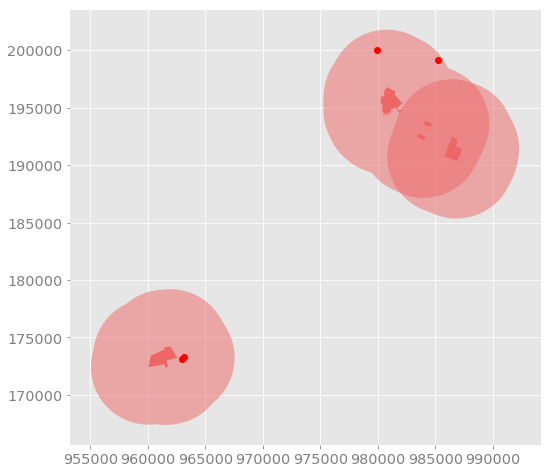

In [50]:
# Converting the crs to feet
cts_ft = cts.to_crs(epsg=2263)
gld_ft = geo_library_data.to_crs(epsg=2263)

# Plotting the Census Track Area for ct = 9
ax=cts_ft[(cts_ft.ctlabel == "9").values].plot()

# Distance between Centroid and the Library
cts_ft['center_ct'] = cts_ft.centroid
gld_ft['loc_library'] = gld_ft['geometry']

# Creating buffers for all cts
cts_ft["buffer"] = cts_ft.geometry.buffer(5000)
cts_ft["geometry_original"] = cts_ft["geometry"]
cts_ft["geometry"] = cts_ft["buffer"]

# Plotting the one mile location for ct = 9
cts_ft[(cts_ft.ctlabel == "9").values].plot(ax=ax, alpha=0.5)

# Plotting the libraries I get as a result of spatial join that are associated with the census track
# gld_ft[gld_ft.index.isin([89, 57, 71, 67, 72, 69, 64, 60, 63])].plot(ax=ax, color="red")
gld_ft[gld_ft.index.isin([81, 86, 57, 56])].plot(ax=ax, color="red")

**Fig: This figures depicts for the census tract '9', the number of libraries (in red) within 1 mile of its location.** 

Since the census tract '9' is repeated across two boroughs (Manhattan and Staten Island), we have two circles.

In [51]:
# Visualizing the Head
cts_ft.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,center_ct,buffer,geometry_original
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((960666.9408794498 167463.9060371463,...",POINT (961255.5880216487 173259.546513908),"POLYGON ((960666.9408794498 167463.9060371463,...","POLYGON ((962269.1260375973 173705.5001830565,..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((996551.3680476212 219225.4199519744,...",POINT (993177.9755822707 214632.286249557),"POLYGON ((996551.3680476212 219225.4199519744,...","POLYGON ((994133.5070190424 214848.8975829605,..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((995527.0999700523 220389.1375048436,...",POINT (992219.9697992787 215461.7730641492),"POLYGON ((995527.0999700523 220389.1375048436,...","POLYGON ((993108.3057861348 216013.1307982849,..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((994677.7428944287 220859.9825322611,...",POINT (991328.3785938525 215956.2980855249),"POLYGON ((994677.7428944287 220859.9825322611,...","POLYGON ((992216.5391845678 216507.687011669, ..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((993735.797709931 221382.5908234176, ...",POINT (990435.2311938369 216449.805313988),"POLYGON ((993735.797709931 221382.5908234176, ...","POLYGON ((991325.8815917961 217001.6885985838,..."


Now, we need to spatially join our census tract and library data.

In [52]:
spat_joined_cts_gld = gpd.sjoin(cts_ft, gld_ft)

# Visualizing the head
spat_joined_cts_gld.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,...,center_ct,buffer,geometry_original,index_right,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,loc_library
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,POINT (961255.5880216487 173259.546513908),"POLYGON ((960666.9408794498 167463.9060371463,...","POLYGON ((962269.1260375973 173705.5001830565,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1325,5,5001100,Staten Island,E,001100,11,SI22,West New Brighton-New Brighton-St. George,3903,3.496830e+06,...,POINT (961303.9202926488 172010.6376485268),"POLYGON ((956320.6293395378 168300.1639084391,...","POLYGON ((962621.6790161112 171764.4616088345,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1326,5,5001700,Staten Island,E,001700,17,SI37,Stapleton-Rosebank,3903,3.295781e+06,...,POINT (961705.0230642168 170421.6032090251),"POLYGON ((957291.8082661233 166385.9719448599,...","POLYGON ((962621.6790161112 171764.4616088345,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1347,5,5007700,Staten Island,E,007700,77,SI22,West New Brighton-New Brighton-St. George,3903,2.674908e+06,...,POINT (959195.6619256317 171680.1387611967),"POLYGON ((958039.5589932257 177288.2536706291,...","POLYGON ((960079.5504150381 172579.472595159, ...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1362,5,5003300,Staten Island,I,003300,33,SI08,Grymes Hill-Clifton-Fox Hills,3903,9.209412e+06,...,POINT (960202.7280739612 167215.0185102422),"POLYGON ((953851.032005815 167083.0020828393, ...","POLYGON ((961654.0390014652 168922.6130370591,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)


Let us inspect the columns of the spatially joined data.

In [53]:
spat_joined_cts_gld.columns

Index(['boro_code', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'ntacode', 'ntaname', 'puma', 'shape_area', 'shape_leng',
       'geometry', 'center_ct', 'buffer', 'geometry_original', 'index_right',
       'Boro/Central Library', 'Network', 'Branch', 'ADULT Program',
       'ADULT Attendance', 'loc_library'],
      dtype='object')

Let's filter out a specific branch.

In [54]:
spat_joined_cts_gld.loc[(spat_joined_cts_gld['Branch'] == 'St. George Library Center')]

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,...,center_ct,buffer,geometry_original,index_right,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,loc_library
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,POINT (961255.5880216487 173259.546513908),"POLYGON ((960666.9408794498 167463.9060371463,...","POLYGON ((962269.1260375973 173705.5001830565,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1325,5,5001100,Staten Island,E,001100,11,SI22,West New Brighton-New Brighton-St. George,3903,3.496830e+06,...,POINT (961303.9202926488 172010.6376485268),"POLYGON ((956320.6293395378 168300.1639084391,...","POLYGON ((962621.6790161112 171764.4616088345,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1326,5,5001700,Staten Island,E,001700,17,SI37,Stapleton-Rosebank,3903,3.295781e+06,...,POINT (961705.0230642168 170421.6032090251),"POLYGON ((957291.8082661233 166385.9719448599,...","POLYGON ((962621.6790161112 171764.4616088345,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1347,5,5007700,Staten Island,E,007700,77,SI22,West New Brighton-New Brighton-St. George,3903,2.674908e+06,...,POINT (959195.6619256317 171680.1387611967),"POLYGON ((958039.5589932257 177288.2536706291,...","POLYGON ((960079.5504150381 172579.472595159, ...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1362,5,5003300,Staten Island,I,003300,33,SI08,Grymes Hill-Clifton-Fox Hills,3903,9.209412e+06,...,POINT (960202.7280739612 167215.0185102422),"POLYGON ((953851.032005815 167083.0020828393, ...","POLYGON ((961654.0390014652 168922.6130370591,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1610,5,5002100,Staten Island,E,002100,21,SI37,Stapleton-Rosebank,3903,9.417086e+06,...,POINT (962777.0524773683 168971.7018290311),"POLYGON ((956816.5914213761 170385.7530141708,...","POLYGON ((964105.8546142592 171704.1494140084,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1618,5,5000300,Staten Island,I,000300,3,SI22,West New Brighton-New Brighton-St. George,3903,4.119894e+06,...,POINT (963359.7270365293 172974.7276811684),"POLYGON ((957422.9424968105 172487.2654961047,...","POLYGON ((964105.8546142592 171704.1494140084,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1796,5,5007500,Staten Island,E,007500,75,SI35,New Brighton-Silver Lake,3903,5.158899e+06,...,POINT (959008.834287353 170124.425440116),"POLYGON ((952826.5615703313 172592.5260916006,...","POLYGON ((960414.8384399394 171251.9752196682,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
1896,5,5006700,Staten Island,I,006700,67,SI35,New Brighton-Silver Lake,3903,1.025649e+07,...,POINT (956191.8823262054 170710.9087155371),"POLYGON ((949876.3893203057 168885.4921278241,...","POLYGON ((958136.017639162 172192.5767821713, ...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)
2164,5,5000700,Staten Island,E,000700,7,SI22,West New Brighton-New Brighton-St. George,3903,5.500153e+06,...,POINT (961386.724118094 174675.2183551253),"POLYGON ((955136.6767817332 172575.2557026629,...","POLYGON ((963725.8973999048 174346.3251952545,...",81,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,POINT (962962.9225494306 173087.9366904366)


The above table indicates this library is located within 1 mile of 11 (census_tract, boro).

In [55]:
# Confirming the type of the data
type(spat_joined_cts_gld)

geopandas.geodataframe.GeoDataFrame

In [56]:
# Selecting only the relevant columns
new_df = spat_joined_cts_gld[['ctlabel', 'puma', 'boro_name', 'Boro/Central Library', 'Network', 'Branch', 'ADULT Program', 'ADULT Attendance',
                              'index_right', 'geometry', 'center_ct', 'loc_library']]

# Visualizing the head
new_df.head()

,ctlabel,puma,boro_name,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,index_right,geometry,center_ct,loc_library
0,9,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((960666.9408794498 167463.9060371463,...",POINT (961255.5880216487 173259.546513908),POINT (962962.9225494306 173087.9366904366)
1325,11,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((956320.6293395378 168300.1639084391,...",POINT (961303.9202926488 172010.6376485268),POINT (962962.9225494306 173087.9366904366)
1326,17,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((957291.8082661233 166385.9719448599,...",POINT (961705.0230642168 170421.6032090251),POINT (962962.9225494306 173087.9366904366)
1347,77,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((958039.5589932257 177288.2536706291,...",POINT (959195.6619256317 171680.1387611967),POINT (962962.9225494306 173087.9366904366)
1362,33,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((953851.032005815 167083.0020828393, ...",POINT (960202.7280739612 167215.0185102422),POINT (962962.9225494306 173087.9366904366)


Let us see what borough name we get for **Boro/Central Library == 'Central Library Units'**.

In [57]:
new_df.loc[(new_df['Boro/Central Library'] == 'CENTRAL LIBRARY UNITS')]

,ctlabel,puma,boro_name,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,index_right,geometry,center_ct,loc_library
1,98,3808,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((996551.3680476212 219225.4199519744,...",POINT (993177.9755822707 214632.286249557),POINT (988967.3435885529 211891.5767740879)
2,100,3808,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((995527.0999700523 220389.1375048436,...",POINT (992219.9697992787 215461.7730641492),POINT (988967.3435885529 211891.5767740879)
3,102,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((994677.7428944287 220859.9825322611,...",POINT (991328.3785938525 215956.2980855249),POINT (988967.3435885529 211891.5767740879)
4,104,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((993735.797709931 221382.5908234176, ...",POINT (990435.2311938369 216449.805313988),POINT (988967.3435885529 211891.5767740879)
5,113,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((991077.5234418919 218657.7261427606,...",POINT (987610.6782485553 214261.8441480271),POINT (988967.3435885529 211891.5767740879)
637,119,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((991602.4888532689 219580.0389783874,...",POINT (988121.7376860498 215187.3554958467),POINT (988967.3435885529 211891.5767740879)
638,125,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((992093.9660854283 220503.6336451563,...",POINT (988633.8908283029 216107.5488269113),POINT (988967.3435885529 211891.5767740879)
647,56,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((991070.0280845148 214468.0608285889,...",POINT (987770.0928475565 209531.5280529969),POINT (988967.3435885529 211891.5767740879)
762,121,3807,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((990032.0048661178 220454.7979994306,...",POINT (986549.5431634892 216059.6072107088),POINT (988967.3435885529 211891.5767740879)
809,92,3808,Manhattan,CENTRAL LIBRARY UNITS,Central,SIBL,0.0,0.0,92,"POLYGON ((987498.7112945673 218120.499065277, ...",POINT (991248.4372637034 213851.4931607582),POINT (988967.3435885529 211891.5767740879)


As suspected, the central library units do correspond to a specific borough.

In [58]:
new_df.loc[(new_df.ctlabel == '9')]

,ctlabel,puma,boro_name,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,index_right,geometry,center_ct,loc_library
0,9,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((960666.9408794498 167463.9060371463,...",POINT (961255.5880216487 173259.546513908),POINT (962962.9225494306 173087.9366904366)
0,9,3903,Staten Island,Staten Island,Special Units,Staten Island Borough Office,0.0,0.0,86,"POLYGON ((960666.9408794498 167463.9060371463,...",POINT (961255.5880216487 173259.546513908),POINT (963148.5759931649 173332.6392483635)
1864,9,3810,Manhattan,Manhattan,Seward Park Network,Chatham Square,70.0,1176.0,57,"POLYGON ((975281.1301259823 194966.1024631598,...",POINT (981526.376830276 195129.1725158601),POINT (985221.3699713827 199163.3717431173)
1864,9,3810,Manhattan,Manhattan,Seward Park Network,Battery Park City,87.0,511.0,56,"POLYGON ((975281.1301259823 194966.1024631598,...",POINT (981526.376830276 195129.1725158601),POINT (979898.3831970072 200035.0020153162)


The above tables indicates the census tract 9 across two boroughs have 4 libraries within 1 mile.

Now, we need to calculate the distance between the center of the census tract and location of the library.

In [59]:
# list to store the distances
distance_centerct_lib_list = []

# Iterating over the center of the census tract and the library location
for i, j in zip(new_df.center_ct, new_df.loc_library):
    
    # Calculating the distance: point.distance(point)
    dist = shapely.geometry.shape(i).distance(shapely.geometry.shape(j))
    
    # Appending to the list
    distance_centerct_lib_list.append(dist)

# Creating a new column based on this list    
new_df['distance_from_ct_to_lib'] = distance_centerct_lib_list

# Visualizing the head
new_df.head()

,ctlabel,puma,boro_name,Boro/Central Library,Network,Branch,ADULT Program,ADULT Attendance,index_right,geometry,center_ct,loc_library,distance_from_ct_to_lib
0,9,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((960666.9408794498 167463.9060371463,...",POINT (961255.5880216487 173259.546513908),POINT (962962.9225494306 173087.9366904366),1715.937389
1325,11,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((956320.6293395378 168300.1639084391,...",POINT (961303.9202926488 172010.6376485268),POINT (962962.9225494306 173087.9366904366),1978.095476
1326,17,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((957291.8082661233 166385.9719448599,...",POINT (961705.0230642168 170421.6032090251),POINT (962962.9225494306 173087.9366904366),2948.159655
1347,77,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((958039.5589932257 177288.2536706291,...",POINT (959195.6619256317 171680.1387611967),POINT (962962.9225494306 173087.9366904366),4021.709539
1362,33,3903,Staten Island,Staten Island,Staten Island Network,St. George Library Center,112.0,1299.0,81,"POLYGON ((953851.032005815 167083.0020828393, ...",POINT (960202.7280739612 167215.0185102422),POINT (962962.9225494306 173087.9366904366),6489.209620


Now, we need to:

1. count the number of libraries,
2. get the mean attendance across all the libraries,
3. get the distance to the closest library

per (census_tract, borough).

In [60]:
# Grouping by (ctlabel, boro_name), aggregating across index_right (uniquely identifies a library), 
# ADULT Attendance, and distance_from_ct_to_lib
agg_df = new_df.groupby(by=['ctlabel', 'boro_name'], as_index=False).agg({'index_right': 'count', 
                                                   'ADULT Attendance': 'mean', 
                                                    'distance_from_ct_to_lib': 'min'}) 
                                                   
# Renaming the columns appropriately   
agg_df.rename(columns={'index_right': 'Number of Libraries', 'distance_from_ct_to_lib': 'Distance to Closest Library'}
              , inplace=True)

# Visualizing the head
agg_df.head()

,ctlabel,boro_name,Distance to Closest Library,ADULT Attendance,Number of Libraries
0,1,Brooklyn,4837.327735,810.500000,2
1,1,Queens,6566.284564,877.666667,3
2,10.01,Manhattan,2079.896212,1147.250000,4
3,10.02,Manhattan,1156.027025,1043.000000,6
4,100,Manhattan,599.563372,3855.750000,12


In [61]:
# Sorting based on ctlabel, boro_name
new_df2 = new_df.loc[:, ['ctlabel', 'boro_name', 'geometry']].sort_values(['ctlabel', 'boro_name']).copy()

# Visualizing the head
new_df2.head()

,ctlabel,boro_name,geometry
1291,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98..."
1291,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98..."
1960,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ..."
1960,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ..."
1960,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ..."


We need to merge the aggregated df with the original geodf so that we get a geoDataFrame.

In [62]:
# Merging both the dataFrames on ctlabel, boro_name
merged_agg_df = new_df2.merge(agg_df, on=['ctlabel', 'boro_name'], right_index=True)

# Removing duplicated indices
merged_agg_df = merged_agg_df[~merged_agg_df.index.duplicated(keep='first')].reset_index(drop=True)

# Visualizing the head
merged_agg_df.head()

,ctlabel,boro_name,geometry,Distance to Closest Library,ADULT Attendance,Number of Libraries
0,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98...",4837.327735,810.500000,2
1,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ...",6566.284564,877.666667,3
2,10.01,Manhattan,"POLYGON ((985512.8668404599 202106.02195677, 9...",2079.896212,1147.250000,4
3,10.02,Manhattan,"POLYGON ((985146.7899090922 202535.0873095479,...",1156.027025,1043.000000,6
4,100,Manhattan,"POLYGON ((995527.0999700523 220389.1375048436,...",599.563372,3855.750000,12


(900876.86658980278, 1061464.68089797, 106986.06879141729, 285980.3520349972)

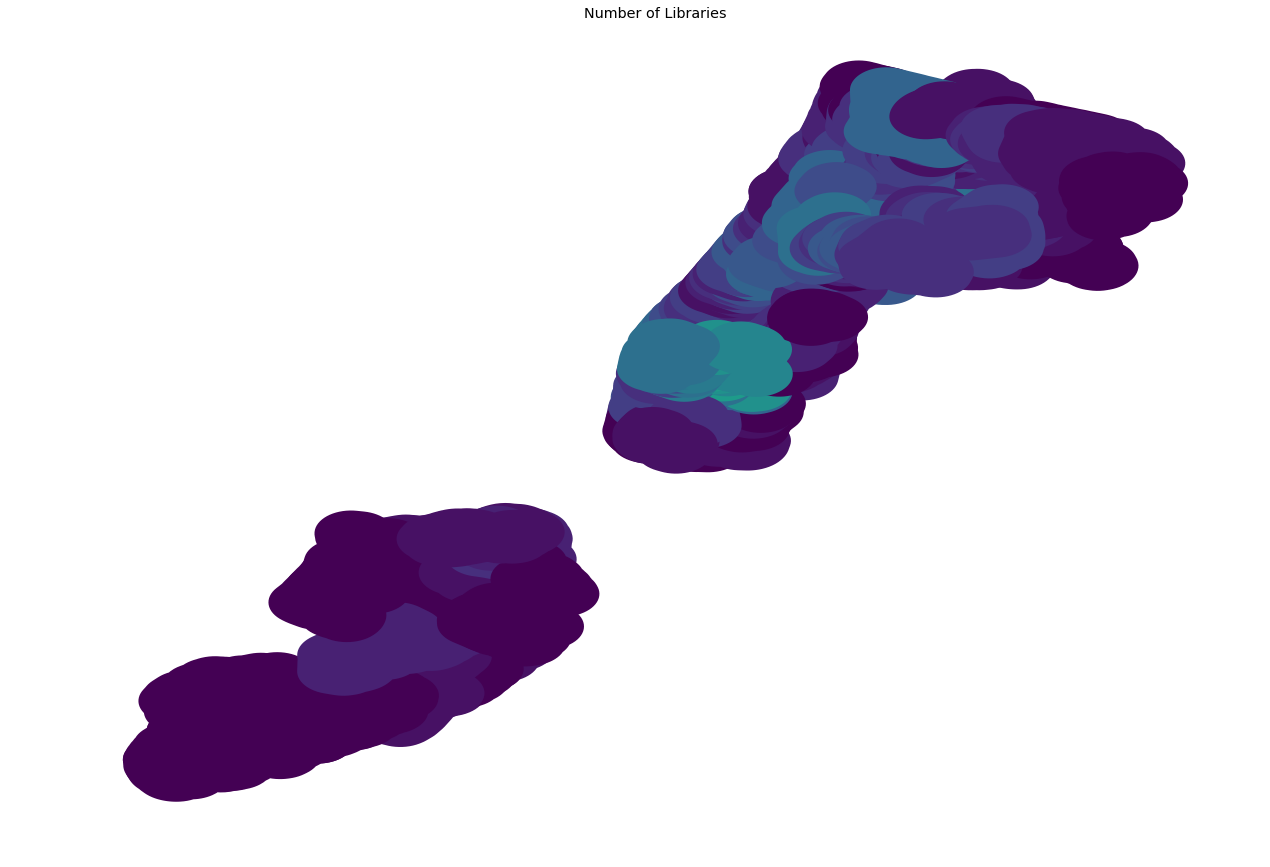

In [63]:
fig = pl.figure(figsize=(21,15))
ax = fig.add_subplot(111)
merged_agg_df.plot(column="Number of Libraries", ax=ax, label=True)
ax.set_title("Number of Libraries")
ax.axis('off')

In [64]:
agg_df['Number of Libraries'].value_counts()

4     123
5     114
2      89
6      87
1      86
3      83
7      51
8      36
11     18
9      15
13     13
10     13
12     11
14      3
23      1
Name: Number of Libraries, dtype: int64

Mostly, the Number of Libraries are < 10!

In [65]:
agg_df.loc[(agg_df['Number of Libraries'] == 23)]

,ctlabel,boro_name,Distance to Closest Library,ADULT Attendance,Number of Libraries
91,143,Manhattan,3408.137213,2698.652174,23


We have a census tract that has 23 libraries within a mile!

In [66]:
agg_df['boro_name'].value_counts()

Bronx            338
Manhattan        286
Staten Island     91
Queens            17
Brooklyn          11
Name: boro_name, dtype: int64

In [67]:
merged_agg_df.head()

,ctlabel,boro_name,geometry,Distance to Closest Library,ADULT Attendance,Number of Libraries
0,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98...",4837.327735,810.500000,2
1,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ...",6566.284564,877.666667,3
2,10.01,Manhattan,"POLYGON ((985512.8668404599 202106.02195677, 9...",2079.896212,1147.250000,4
3,10.02,Manhattan,"POLYGON ((985146.7899090922 202535.0873095479,...",1156.027025,1043.000000,6
4,100,Manhattan,"POLYGON ((995527.0999700523 220389.1375048436,...",599.563372,3855.750000,12


Now we merge this geodataFrame with the ACF dataFrame to get the socioeconomic data.

In [68]:
merged_agg_df2 = merged_agg_df.merge(aff_df, left_on=['ctlabel', 'boro_name'], 
                                     right_on=['census_tract', 'borough'])[['ctlabel', 'boro_name', 'geometry',
                                                                           'Number of Libraries', 'ADULT Attendance',
                                                                           'unemployed_fraction', 'total_surveyed', 
                                                                           'Distance to Closest Library']]

merged_agg_df2.head()

,ctlabel,boro_name,geometry,Number of Libraries,ADULT Attendance,unemployed_fraction,total_surveyed,Distance to Closest Library
0,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98...",2,810.500000,0.000000,94,4837.327735
1,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ...",3,877.666667,0.000000,46,6566.284564
2,10.01,Manhattan,"POLYGON ((985512.8668404599 202106.02195677, 9...",4,1147.250000,NaN,0,2079.896212
3,10.02,Manhattan,"POLYGON ((985146.7899090922 202535.0873095479,...",6,1043.000000,0.262376,202,1156.027025
4,100,Manhattan,"POLYGON ((995527.0999700523 220389.1375048436,...",12,3855.750000,0.000000,17,599.563372


In [69]:
len(merged_agg_df2) == len(merged_agg_df)

True

In [70]:
merged_agg_df2

,ctlabel,boro_name,geometry,Number of Libraries,ADULT Attendance,unemployed_fraction,total_surveyed,Distance to Closest Library
0,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98...",2,810.500000,0.000000,94,4837.327735
1,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ...",3,877.666667,0.000000,46,6566.284564
2,10.01,Manhattan,"POLYGON ((985512.8668404599 202106.02195677, 9...",4,1147.250000,NaN,0,2079.896212
3,10.02,Manhattan,"POLYGON ((985146.7899090922 202535.0873095479,...",6,1043.000000,0.262376,202,1156.027025
4,100,Manhattan,"POLYGON ((995527.0999700523 220389.1375048436,...",12,3855.750000,0.000000,17,599.563372
5,101,Manhattan,"POLYGON ((989987.7617318475 216858.4544236407,...",13,3265.384615,1.000000,8,1270.356912
6,102,Manhattan,"POLYGON ((994677.7428944287 220859.9825322611,...",12,3853.500000,NaN,0,948.494694
7,103,Manhattan,"POLYGON ((979609.005266863 215694.0323809566, ...",9,4484.000000,NaN,0,2801.149151
8,104,Manhattan,"POLYGON ((993735.797709931 221382.5908234176, ...",14,3361.928571,0.000000,34,85.964168
9,105,Staten Island,"POLYGON ((946807.5317915451 169553.0106821361,...",2,775.000000,0.278689,122,865.247583


In [71]:
merged_agg_df2['Number of Libraries per Person'] = merged_agg_df2['Number of Libraries'] / merged_agg_df2.total_surveyed
merged_agg_df2['Number of People per Library'] = merged_agg_df2.total_surveyed / merged_agg_df2['Number of Libraries']

merged_agg_df2.head()

,ctlabel,boro_name,geometry,Number of Libraries,ADULT Attendance,unemployed_fraction,total_surveyed,Distance to Closest Library,Number of Libraries per Person,Number of People per Library
0,1,Brooklyn,"POLYGON ((980323.2887558538 196069.1237889, 98...",2,810.500000,0.000000,94,4837.327735,0.021277,47.000000
1,1,Queens,"POLYGON ((989978.055206397 210503.4073845278, ...",3,877.666667,0.000000,46,6566.284564,0.065217,15.333333
2,10.01,Manhattan,"POLYGON ((985512.8668404599 202106.02195677, 9...",4,1147.250000,NaN,0,2079.896212,inf,0.000000
3,10.02,Manhattan,"POLYGON ((985146.7899090922 202535.0873095479,...",6,1043.000000,0.262376,202,1156.027025,0.029703,33.666667
4,100,Manhattan,"POLYGON ((995527.0999700523 220389.1375048436,...",12,3855.750000,0.000000,17,599.563372,0.705882,1.416667


# Analysis

In [72]:
# Correlation of unemployed_fraction with ADULT attendance
# Correlation between Number of Libraries reachable on foot and Adult Attendance
# Correlation between Number of Libraries reachable on foot and unemployed Fraction
# Correlation between Distance to Closest Library and unemployed Fraction
# Correlation between Adult Attendance and Unemployed Fraction

Text(0,0.5,'Number of census tract, boro')

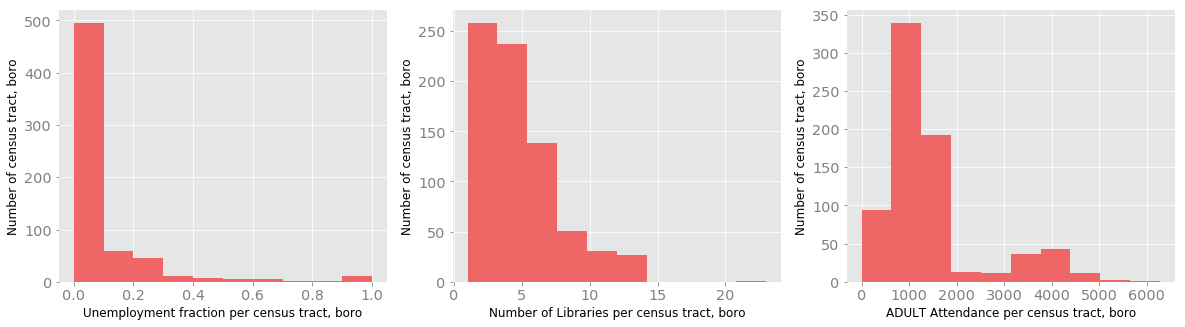

In [73]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(131)
merged_agg_df2.unemployed_fraction.hist(ax=ax)
ax.set_xlabel("Unemployment fraction per census tract, boro")
ax.set_ylabel("Number of census tract, boro")

ax = fig.add_subplot(132)
merged_agg_df2['Number of Libraries'].hist(ax=ax)
ax.set_xlabel("Number of Libraries per census tract, boro")
ax.set_ylabel("Number of census tract, boro")

ax = fig.add_subplot(133)
merged_agg_df2['ADULT Attendance'].hist(ax=ax)
ax.set_xlabel("ADULT Attendance per census tract, boro")
ax.set_ylabel("Number of census tract, boro")

In [74]:
len(merged_agg_df2)

743

In [75]:
nans_removed_merged_agg_df2 = merged_agg_df2[np.isfinite(merged_agg_df2.unemployed_fraction)].copy()

## Correlation between Variables

In [76]:
def plot_scatter(x, y, xlabel, ylabel, title):
    '''
    x: a list, column, series for the x-axis,
    y: a list, column, series for the y-axis,
    xlabel: a string, label for the x-axis,
    ylabel: a string, label for the y-axis,
    title: a string, title for the plot
    '''
    plt.plot(x, y, 'bo')
    plt.axis(aspect='equal')
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, rotation='horizontal', ha='right')

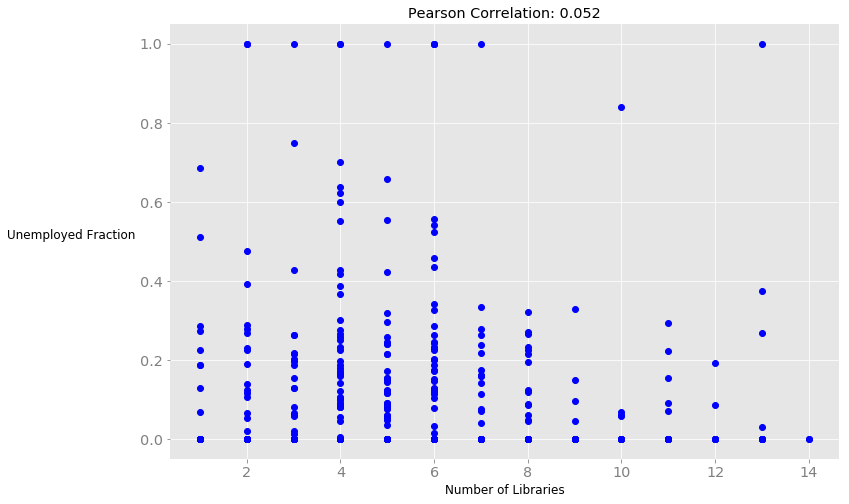

In [77]:
x = nans_removed_merged_agg_df2['Number of Libraries']
y = nans_removed_merged_agg_df2.unemployed_fraction

pearson_res = sp.stats.pearsonr(x, y)

xlabel='Number of Libraries'
ylabel='Unemployed Fraction'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)


**Fig:** Scatter plot between Number of Libraries (x-axis) and Unemployment Fraction (y-axis) is shown. Based on the plot and the Pearson Correlation (0.052), there does not seem to be a correlation between these variables. Thus, we say that the Unemployed Fraction is not associated with the Number of Libraries per (census tract, borough).

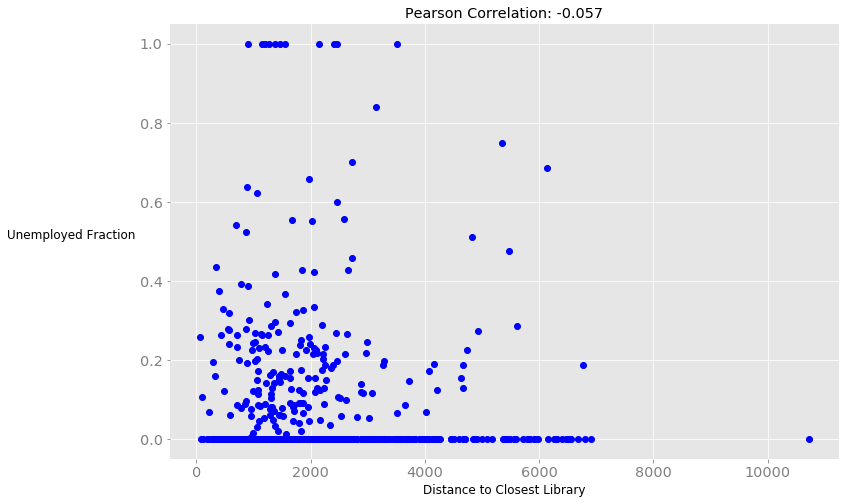

In [78]:
x = nans_removed_merged_agg_df2['Distance to Closest Library']
y = nans_removed_merged_agg_df2.unemployed_fraction

pearson_res = sp.stats.pearsonr(x, y)

xlabel='Distance to Closest Library'
ylabel='Unemployed Fraction'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)

**Fig:** Scatter plot between Distance to Closest Library (x-axis) and Unemployment Fraction (y-axis) is shown. Based on the plot and the Pearson Correlation (-0.057), there does not seem to be a correlation between these variables. It is interesting to note that the unemployed rate is mostly 0 (as indicated by the almost horizontal line at the bottom) irrespective of the distance to the closest library. If we do not consider the unemployed rate at 0, there seems to be a weak positive correlation between the two. However, we say that the Unemployed Fraction is not associated with the Number of Libraries per (census tract, borough) because we cannot simply ignored the unemployed rate at 0.

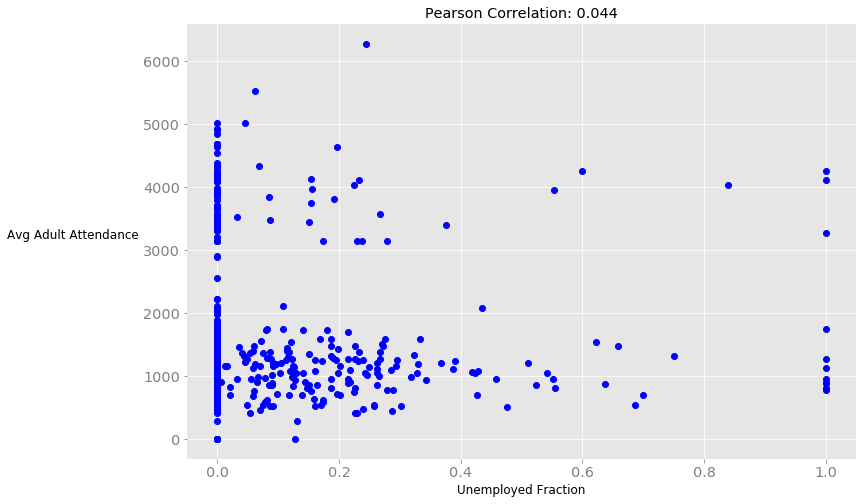

In [79]:
x = nans_removed_merged_agg_df2.unemployed_fraction
y = nans_removed_merged_agg_df2['ADULT Attendance']

pearson_res = sp.stats.pearsonr(x, y)

xlabel='Unemployed Fraction'
ylabel='Avg Adult Attendance'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)

**Fig:** Scatter plot between Unemployed Fraction (x-axis) and Avg Adult Attendance (y-axis) is shown. Based on the plot and the Pearson Correlation (0.044), there does not seem to be a correlation between these variables. Again, it is interesting to note that the unemployed rate is mostly 0 (as indicated by the almost vertical line towards the left) irrespective of the avg adult attendance across all the libraries at walkable distance (within 1 mile). Thus, we say that the Unemployed Fraction is not associated with the Avg Adult Attendance per (census tract, borough).

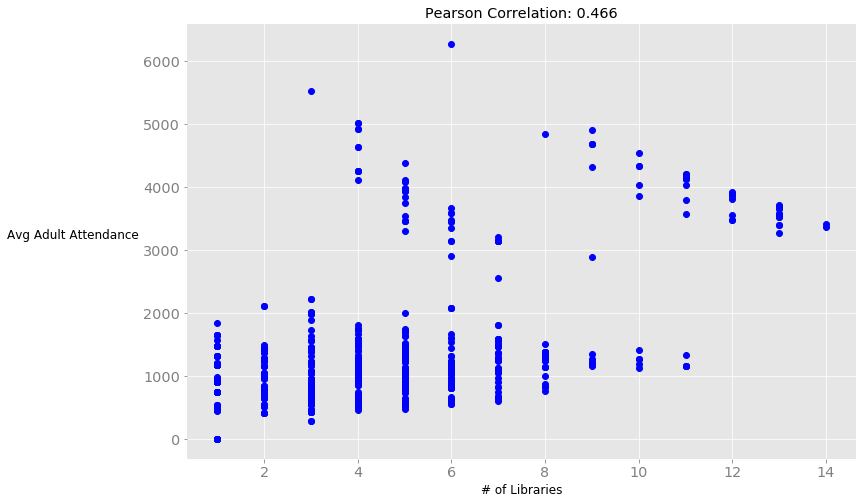

In [80]:
x = nans_removed_merged_agg_df2['Number of Libraries']
y = nans_removed_merged_agg_df2['ADULT Attendance']

pearson_res = sp.stats.pearsonr(x, y)

xlabel='# of Libraries'
ylabel='Avg Adult Attendance'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)

**Fig:** Scatter plot between # of Libraries (x-axis) and Avg Adult Attendance (y-axis) is shown. Based on the plot and the Pearson Correlation (0.466), there seems to be a positive correlation between these variables. The more # of libraries, higher the avg adult attendance is. This makes sense because you would expect the adult attendance to go up as you increase the number of libraries which could then shift the mean of the adult attendance. Thus, we say that the Avg Adult Attendance is positively associated with the # of Libraries at walkable distance (within 1 mile) per (census tract, borough).

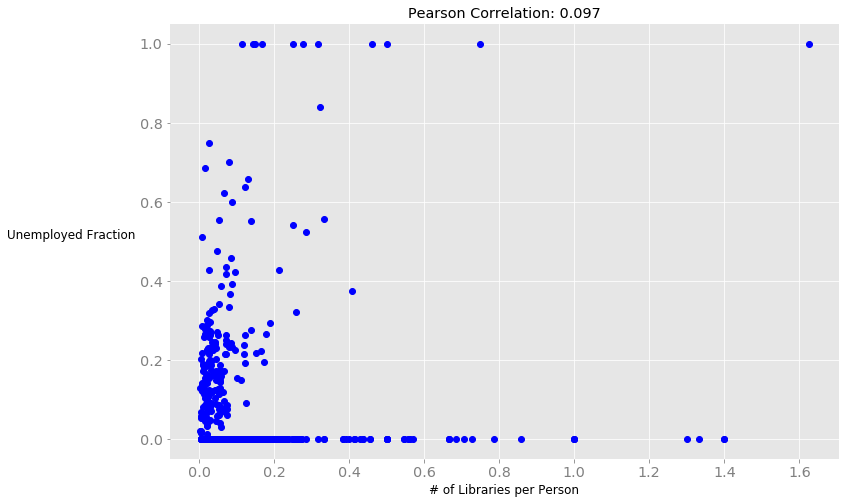

In [81]:
x = nans_removed_merged_agg_df2['Number of Libraries per Person']
y = nans_removed_merged_agg_df2.unemployed_fraction

pearson_res = sp.stats.pearsonr(x, y)

xlabel='# of Libraries per Person'
ylabel='Unemployed Fraction'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)

**Fig:** Scatter plot between # of Libraries per Person (x-axis) and Unemployed Fraction (y-axis) is shown. Based on the plot and the Pearson Correlation (0.097), there does not seem to be a correlation between these variables. Again, it is interesting to note that the unemployed rate is mostly 0 (as indicated by the almost horizontal line towards at the bottom) irrespective of the # of libraries at walkable distance per person living in a census tract, borough. If we ignore the unemployed Fraction at 0, there seems to be a weak positive correlation between the # of Libraries per Person and unemployed fraction, i.e., the more number of libraries per person, higher the unemployed fraction. However, we say that the Unemployed Fraction is not associated with the # of Libraries per Person per (census tract, borough) as we cannot just ignore the the unemployed fraction at 0.

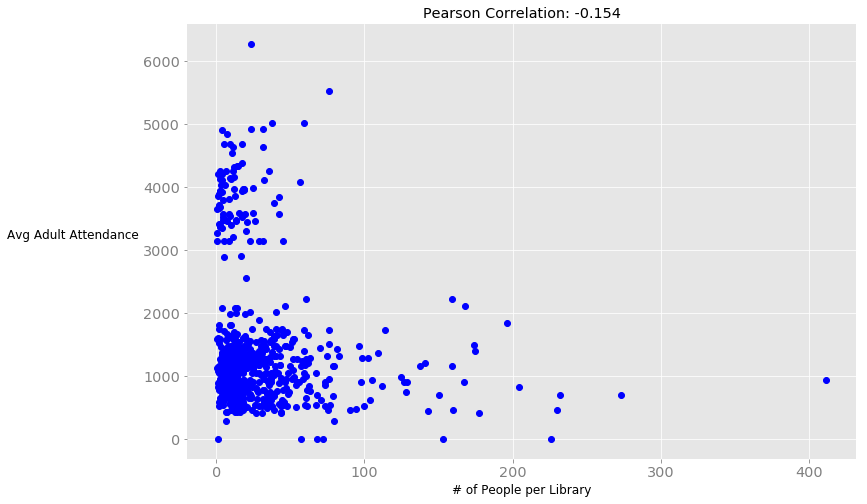

In [82]:
x = nans_removed_merged_agg_df2['Number of People per Library']
y = nans_removed_merged_agg_df2['ADULT Attendance']

pearson_res = sp.stats.pearsonr(x, y)

xlabel='# of People per Library'
ylabel='Avg Adult Attendance'
title ='Pearson Correlation: %s'%round(pearson_res[0], 3)

plot_scatter(x, y, xlabel, ylabel, title)

**Fig:** Scatter plot between # of People per Library (x-axis) and Avg Adult Attendance (y-axis) is shown. Based on the plot and the Pearson Correlation (-0.154), there seems to be a weak negative correlation between these variables. 
That is, the higher number of people living at a walkable distance per library, less the average adult attendance across libraries will be. This is kind of surprising as you would expect people to frequent libraries more if they live at a walkable distance. Thus, we say that the Avg Adult Attendance is weakly and negatively associated with the # of People per Library per (census tract, borough).

## Linear Modeling

We will see whether the average attendance across libraries in a (census tract, borough) can be predicted based on the unemployment rate, distance to the closest library, and # of people per library in that (census tract, borough).

i.e.,

y = Avg Adult Attendance (dependent variable), <br >
x1 = Unemployment Fraction (indepedent variable), <br >
x2 = Distance to the Closest Library (independent variable), <br >
x3 = Number of People Living at a Walkable Distance per Library (independent variable).

In [83]:
nans_removed_merged_agg_df2 = nans_removed_merged_agg_df2.rename(columns={'ADULT Attendance': 'avg_adult_attendance', 
                                                               'Distance to Closest Library': 'dist_to_closest_lib', 
                                     'Number of People per Library': 'people_per_library'})

nans_removed_merged_agg_df2.columns

Index(['ctlabel', 'boro_name', 'geometry', 'Number of Libraries',
       'avg_adult_attendance', 'unemployed_fraction', 'total_surveyed',
       'dist_to_closest_lib', 'Number of Libraries per Person',
       'people_per_library'],
      dtype='object')

In [84]:
import statsmodels.formula.api as smf

formula_1 = 'avg_adult_attendance ~  unemployed_fraction+dist_to_closest_lib+people_per_library'
linear_model_1 = smf.ols(formula=formula_1, data=nans_removed_merged_agg_df2).fit()

linear_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_adult_attendance   R-squared:                       0.054
Model:                              OLS   Adj. R-squared:                  0.049
Method:                   Least Squares   F-statistic:                     12.11
Date:                  Thu, 13 Dec 2018   Prob (F-statistic):           1.03e-07
Time:                          16:22:45   Log-Likelihood:                -5368.5
No. Observations:                   642   AIC:                         1.075e+04
Df Residuals:                       638   BIC:                         1.076e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1816.4804     81.825     22.200      0.000      1655.801  1977.159
unemployed_fraction   193.6184    234.141      0.827      0.409      -266.161   653.398
dist_to_closest_lib    -0.1308      0.030     -4.370      0.000        -0.190    -0.072
people_per_library     -3.5287      1.082     -3.262      0.001        -5.653    -1.405
==============================================================================
Omnibus:                      215.060   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              521.923
Skew:                           1.777   Prob(JB):                    4.63e-114
Kurtosis:                       5.623   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
import statsmodels.formula.api as smf

formula_2 = 'avg_adult_attendance ~  dist_to_closest_lib+people_per_library'
linear_model_2 = smf.ols(formula=formula_2, data=nans_removed_merged_agg_df2).fit()

linear_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_adult_attendance   R-squared:                       0.053
Model:                              OLS   Adj. R-squared:                  0.050
Method:                   Least Squares   F-statistic:                     17.82
Date:                  Thu, 13 Dec 2018   Prob (F-statistic):           2.93e-08
Time:                          16:22:46   Log-Likelihood:                -5368.9
No. Observations:                   642   AIC:                         1.074e+04
Df Residuals:                       639   BIC:                         1.076e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1834.7300     78.773     23.291      0.000      1680.044  1989.416
dist_to_closest_lib    -0.1321      0.030     -4.423      0.000        -0.191    -0.073
people_per_library     -3.5371      1.081     -3.271      0.001        -5.660    -1.414
==============================================================================
Omnibus:                      215.689   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.995
Skew:                           1.781   Prob(JB):                    9.97e-115
Kurtosis:                       5.635   Cond. No.                     4.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I ran an OLS regression which shows that the probability (f-statistic) is lower than my alpha (0.05). This means that the Null hypothesis is rejected. The Null Hypothesis is that the model with just an intercept is equal to your model with intercept + predictive variables. Therefore, the variables (dist_to_closest_lib, people_per_library) have predictive power. Additionally, the 95% confidence interval for both the variables do not include a 0. They range from (-0.191 to -0.073, -5.660 to -1.414), which further confirms that these variables have predictive power. The f-test judges the entire model for it’s predictiveness. I used a t-test to judge the predictability of the individual variables. The t-test shows P > |t| values are less than your alpha (0.05), which reinforces my belief that the individual variables (dist_to_cloest_lib, people_per_library) have predictive power. Lastly, the R-squared value of 0.053 is not that great. This could indicate that a linear model might not be enough to describe the relationship between the predictive variables and target variable.